In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

2021-10-25 16:21:00.263515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-25 16:21:00.263572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(train_x_10, train_y_10), (test_x_10, test_y_10) = tf.keras.datasets.cifar10.load_data()
(train_x_100, train_y_100), (test_x_100, test_y_100) = tf.keras.datasets.cifar100.load_data()

train_x_10 = train_x_10.astype('float32')/255
test_x_10 = test_x_10.astype('float32')/255
train_x_100 = train_x_100.astype('float32')/255
test_x_100 = test_x_100.astype('float32')/255

In [3]:
input_layer = tf.keras.layers.Input(train_x_10.shape[1:])

main_x = tf.keras.layers.Conv2D(
    32,
    3,
    activation = 'relu',
    padding = 'same'
)(input_layer)
ood_x = tf.keras.layers.Flatten()(input_layer)
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(ood_x)

main_x = tf.keras.layers.Conv2D(
    32,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

flatten = tf.keras.layers.Flatten()(main_x)
concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(concat)

main_x = tf.keras.layers.MaxPool2D(2)(main_x)

flatten = tf.keras.layers.Flatten()(main_x)
concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(concat)

main_x = tf.keras.layers.Conv2D(
    64,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

flatten = tf.keras.layers.Flatten()(main_x)
concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(concat)

main_x = tf.keras.layers.Conv2D(
    64,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

flatten = tf.keras.layers.Flatten()(main_x)
concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(concat)

main_x = tf.keras.layers.MaxPool2D(2)(main_x)

flatten = tf.keras.layers.Flatten()(main_x)
concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(concat)

main_x = tf.keras.layers.Conv2D(
    128,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

flatten = tf.keras.layers.Flatten()(main_x)
concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(concat)

main_x = tf.keras.layers.Conv2D(
    128,
    3,
    activation = 'relu',
    padding = 'same'
)(main_x)

flatten = tf.keras.layers.Flatten()(main_x)
concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(concat)

main_x = tf.keras.layers.MaxPool2D(2)(main_x)

flatten = tf.keras.layers.Flatten()(main_x)
concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(concat)

main_x = tf.keras.layers.Flatten()(main_x)
main_x = tf.keras.layers.Dense(128, activation = 'relu')(main_x)

concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(128, activation = 'relu')(concat)

main_x = tf.keras.layers.Dense(10, activation = 'softmax')(main_x)

concat = tf.keras.layers.Concatenate()([ood_x, flatten])
ood_x = tf.keras.layers.Dense(32*32*3, activation = 'sigmoid')(concat)

model = tf.keras.models.Model(input_layer, [main_x, ood_x])
model.compile(
    loss = ['sparse_categorical_crossentropy', 'mae'],
    optimizer = 'adam'
)
model.summary()

2021-10-25 16:21:02.683127: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: UNKNOWN ERROR (304)
2021-10-25 16:21:02.683213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Orion): /proc/driver/nvidia/version does not exist
2021-10-25 16:21:02.683714: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3072)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [4]:
x_train_output = (train_x_10).reshape((train_x_10.shape[0], -1))
x_test_output = (test_x_10).reshape((test_x_10.shape[0], -1))
x_test_100_output = (test_x_100).reshape((test_x_100.shape[0], -1))

model.fit(
    train_x_10,
    [train_y_10, x_train_output],
    validation_split = 0.2,
    epochs = 100,
    batch_size = 256,
    callbacks = [tf.keras.callbacks.EarlyStopping(min_delta = 0.03, patience = 3, restore_best_weights = True)]
)

2021-10-25 16:21:03.959848: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
157/157 [==============================] - 73s 459ms/step - loss: 1.8438 - dense_11_loss: 1.6880 - dense_12_loss: 0.1558 - val_loss: 1.5806 - val_dense_11_loss: 1.4523 - val_dense_12_loss: 0.1282
Epoch 2/100
157/157 [==============================] - 71s 450ms/step - loss: 1.4215 - dense_11_loss: 1.3050 - dense_12_loss: 0.1165 - val_loss: 1.2878 - val_dense_11_loss: 1.1808 - val_dense_12_loss: 0.1070
Epoch 3/100
157/157 [==============================] - 70s 443ms/step - loss: 1.1941 - dense_11_loss: 1.0854 - dense_12_loss: 0.1087 - val_loss: 1.1504 - val_dense_11_loss: 1.0495 - val_dense_12_loss: 0.1010
Epoch 4/100
157/157 [==============================] - 70s 447ms/step - loss: 1.0230 - dense_11_loss: 0.9232 - dense_12_loss: 0.0999 - val_loss: 1.0049 - val_dense_11_loss: 0.9099 - val_dense_12_loss: 0.0950
Epoch 5/100
157/157 [==============================] - 70s 449ms/step - loss: 0.8933 - dense_11_loss: 0.7964 - dense_12_loss: 0.0969 - val_loss: 0.9445 - val_dense_11_l

In [5]:
cifar_10_class_mapping = dict(zip(
    range(10), ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
))

cifar_100_class_mapping = {
    0: 'apple',
    1: 'aquarium_fish',
    2: 'baby',
    3: 'bear',
    4: 'beaver',
    5: 'bed',
    6: 'bee',
    7: 'beetle',
    8: 'bicycle',
    9: 'bottle',
    10: 'bowl',
    11: 'boy',
    12: 'bridge',
    13: 'bus',
    14: 'butterfly',
    15: 'camel',
    16: 'can',
    17: 'castle',
    18: 'caterpillar',
    19: 'cattle',
    20: 'chair',
    21: 'chimpanzee',
    22: 'clock',
    23: 'cloud',
    24: 'cockroach',
    25: 'couch',
    26: 'crab',
    27: 'crocodile',
    28: 'cup',
    29: 'dinosaur',
    30: 'dolphin',
    31: 'elephant',
    32: 'flatfish',
    33: 'forest',
    34: 'fox',
    35: 'girl',
    36: 'hamster',
    37: 'house',
    38: 'kangaroo',
    39: 'keyboard',
    40: 'lamp',
    41: 'lawn_mower',
    42: 'leopard',
    43: 'lion',
    44: 'lizard',
    45: 'lobster',
    46: 'man',
    47: 'maple_tree',
    48: 'motorcycle',
    49: 'mountain',
    50: 'mouse',
    51: 'mushroom',
    52: 'oak_tree',
    53: 'orange',
    54: 'orchid',
    55: 'otter',
    56: 'palm_tree',
    57: 'pear',
    58: 'pickup_truck',
    59: 'pine_tree',
    60: 'plain',
    61: 'plate',
    62: 'poppy',
    63: 'porcupine',
    64: 'possum',
    65: 'rabbit',
    66: 'raccoon',
    67: 'ray',
    68: 'road',
    69: 'rocket',
    70: 'rose',
    71: 'sea',
    72: 'seal',
    73: 'shark',
    74: 'shrew',
    75: 'skunk',
    76: 'skyscraper',
    77: 'snail',
    78: 'snake',
    79: 'spider',
    80: 'squirrel',
    81: 'streetcar',
    82: 'sunflower',
    83: 'sweet_pepper',
    84: 'table',
    85: 'tank',
    86: 'telephone',
    87: 'television',
    88: 'tiger',
    89: 'tractor',
    90: 'train',
    91: 'trout',
    92: 'tulip',
    93: 'turtle',
    94: 'wardrobe',
    95: 'whale',
    96: 'willow_tree',
    97: 'wolf',
    98: 'woman',
    99: 'worm'
}

In [6]:
preds, autoencode = model.predict(train_x_10)
preds = preds.argmax(axis = 1)
preds = [cifar_10_class_mapping[pred] for pred in preds]
similarities = tf.keras.losses.cosine_similarity(x_train_output.astype('float32'), autoencode.astype('float32')).numpy()
print(similarities.mean())
print(similarities.std())

threshold = similarities.mean() + 2*similarities.std()
print(threshold)

-0.97033525
0.017906226
-0.9345227926969528


In [7]:
test_preds, test_autoencode = model.predict(test_x_10)
test_preds = test_preds.argmax(axis = 1)
test_preds = [cifar_10_class_mapping[pred] for pred in test_preds]
test_similarities = tf.keras.losses.cosine_similarity(x_test_output.astype('float32'), test_autoencode.astype('float32')).numpy()
test_trust = test_similarities <= threshold
print(test_similarities.mean())
print(test_similarities.std())

-0.9695774
0.018160656


In [8]:
pd.Series(test_trust).value_counts()

True     9506
False     494
dtype: int64

In [9]:
in_domain_trust = pd.DataFrame()
in_domain_trust['actual_class'] = [cifar_10_class_mapping[val] for val in test_y_10.flatten()]
in_domain_trust['predicted_class'] = test_preds
in_domain_trust['trust'] = test_trust

in_domain_trust.head()

,actual_class,predicted_class,trust
0,cat,cat,True
1,ship,ship,True
2,ship,ship,True
3,airplane,airplane,True
4,frog,frog,True


In [10]:
in_domain_trust.groupby(by = ['actual_class', 'trust']).size().unstack()

trust,False,True
actual_class,,
airplane,19,981
automobile,138,862
bird,46,954
cat,44,956
deer,22,978
dog,36,964
frog,73,927
horse,34,966
ship,16,984


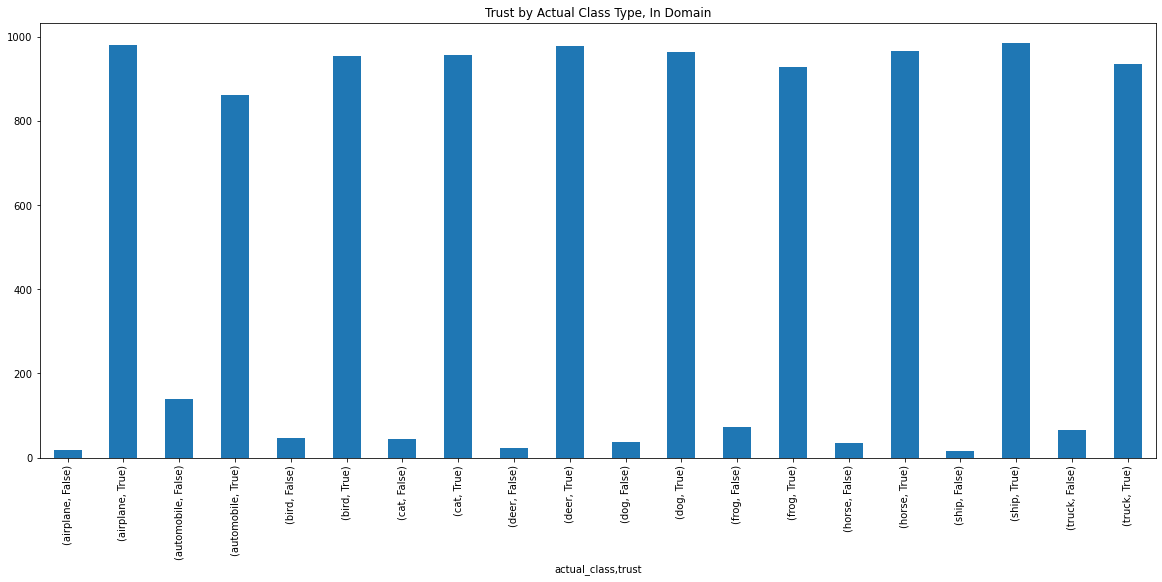

In [11]:
in_domain_trust.groupby(by = ['actual_class', 'trust']).size().plot(kind = 'bar', stacked = True, figsize = (20, 8), title = 'Trust by Actual Class Type, In Domain')
plt.show()

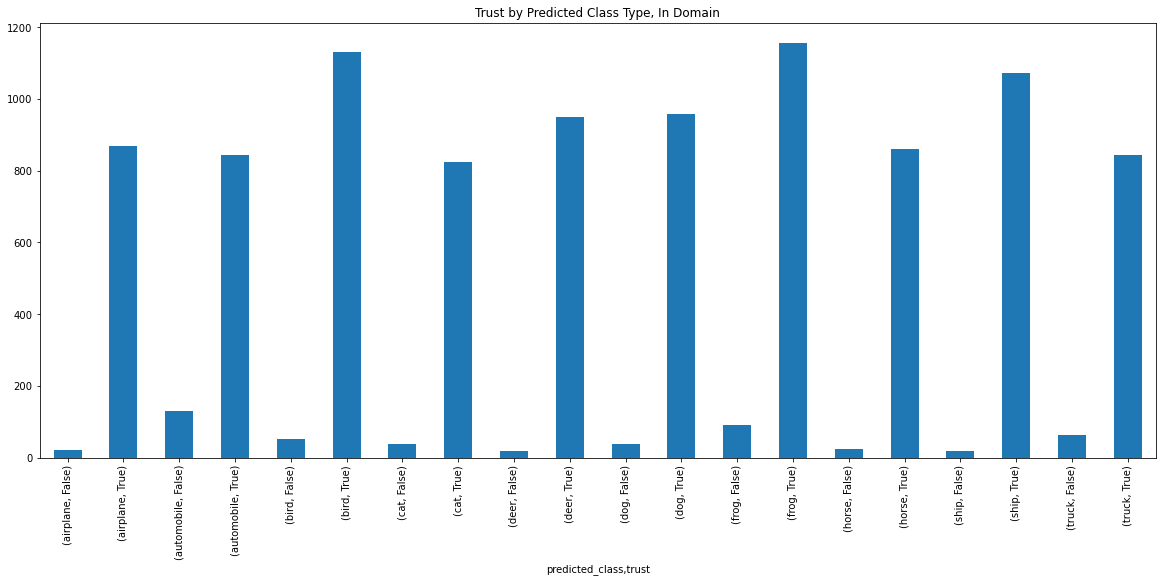

In [12]:
in_domain_trust.groupby(by = ['predicted_class', 'trust']).size().plot(kind = 'bar', stacked = True, figsize = (20, 8), title = 'Trust by Predicted Class Type, In Domain')
plt.show()

In [13]:
print('Global Classification Report, in Domain')
print(classification_report(in_domain_trust['actual_class'], in_domain_trust['predicted_class']))

Global Classification Report, in Domain
              precision    recall  f1-score   support

    airplane       0.81      0.72      0.76      1000
  automobile       0.88      0.85      0.86      1000
        bird       0.59      0.70      0.64      1000
         cat       0.60      0.52      0.55      1000
        deer       0.73      0.70      0.71      1000
         dog       0.64      0.64      0.64      1000
        frog       0.70      0.88      0.78      1000
       horse       0.85      0.75      0.80      1000
        ship       0.81      0.89      0.85      1000
       truck       0.86      0.78      0.82      1000

    accuracy                           0.74     10000
   macro avg       0.75      0.74      0.74     10000
weighted avg       0.75      0.74      0.74     10000



In [14]:
print('Trusted Classification Report, in Domain')
print(classification_report(in_domain_trust[in_domain_trust.trust == True]['actual_class'], in_domain_trust[in_domain_trust.trust == True]['predicted_class']))

Trusted Classification Report, in Domain
              precision    recall  f1-score   support

    airplane       0.82      0.72      0.77       981
  automobile       0.88      0.86      0.87       862
        bird       0.60      0.71      0.65       954
         cat       0.60      0.52      0.56       956
        deer       0.73      0.71      0.72       978
         dog       0.65      0.65      0.65       964
        frog       0.70      0.87      0.78       927
       horse       0.85      0.76      0.80       966
        ship       0.82      0.89      0.85       984
       truck       0.87      0.78      0.82       934

    accuracy                           0.74      9506
   macro avg       0.75      0.75      0.75      9506
weighted avg       0.75      0.74      0.74      9506



In [15]:
print('Untrusted Classification Report, in Domain')
print(classification_report(in_domain_trust[in_domain_trust.trust == False]['actual_class'], in_domain_trust[in_domain_trust.trust == False]['predicted_class']))

Untrusted Classification Report, in Domain
              precision    recall  f1-score   support

    airplane       0.52      0.58      0.55        19
  automobile       0.88      0.83      0.85       138
        bird       0.56      0.63      0.59        46
         cat       0.58      0.50      0.54        44
        deer       0.56      0.45      0.50        22
         dog       0.49      0.53      0.51        36
        frog       0.74      0.92      0.82        73
       horse       0.79      0.56      0.66        34
        ship       0.61      0.69      0.65        16
       truck       0.80      0.77      0.78        66

    accuracy                           0.71       494
   macro avg       0.65      0.65      0.64       494
weighted avg       0.72      0.71      0.71       494



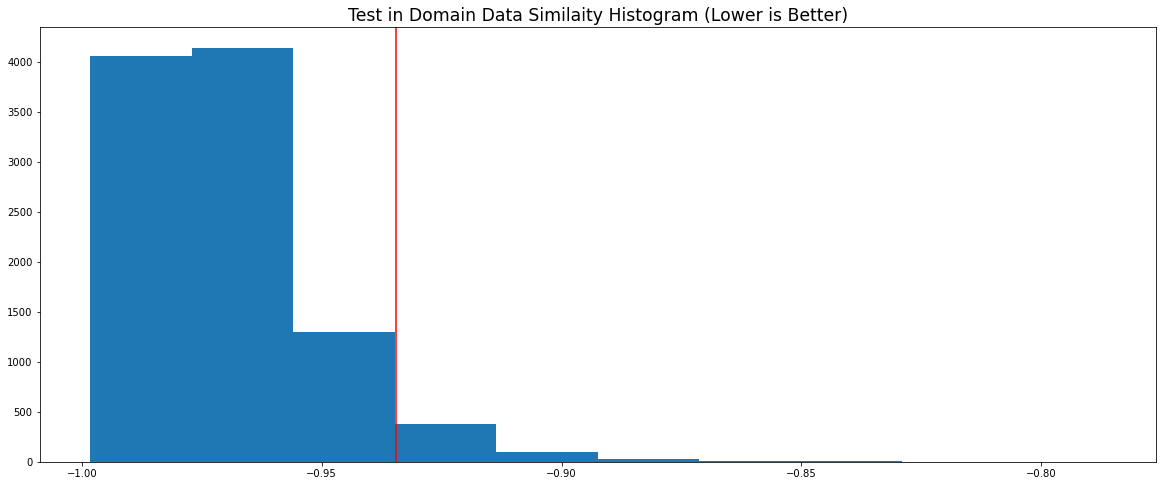

In [16]:
plt.figure(figsize = (20, 8))
plt.title('Test in Domain Data Similaity Histogram (Lower is Better)', fontsize = 'xx-large')
plt.hist(test_similarities)
plt.axvline(threshold, c = 'red')
plt.show()

In [17]:
preds_100, autoencode_100 = model.predict(test_x_100)
preds_100 = preds_100.argmax(axis = 1)
preds_100 = [cifar_10_class_mapping[val] for val in preds_100.flatten()]
similarities_100 = tf.keras.losses.cosine_similarity(x_test_100_output.astype('float32'), autoencode_100.astype('float32'))
trust_100 = (similarities_100 <= threshold).numpy()

In [18]:
pd.Series(trust_100).value_counts()

True     9266
False     734
dtype: int64

In [19]:
ood_trust = pd.DataFrame()
ood_trust['actual_class'] = [cifar_100_class_mapping[val] for val in test_y_100.flatten()]
ood_trust['predicted_class'] = preds_100
ood_trust['trust'] = trust_100
ood_trust.head()

,actual_class,predicted_class,trust
0,mountain,bird,True
1,forest,deer,True
2,seal,bird,True
3,mushroom,deer,True
4,sea,ship,True


In [20]:
ood_trust.groupby(by = ['actual_class', 'trust']).size().unstack()

trust,False,True
actual_class,,
apple,3.0,97.0
aquarium_fish,16.0,84.0
baby,8.0,92.0
bear,5.0,95.0
beaver,2.0,98.0
...,...,...
whale,1.0,99.0
willow_tree,1.0,99.0
wolf,3.0,97.0


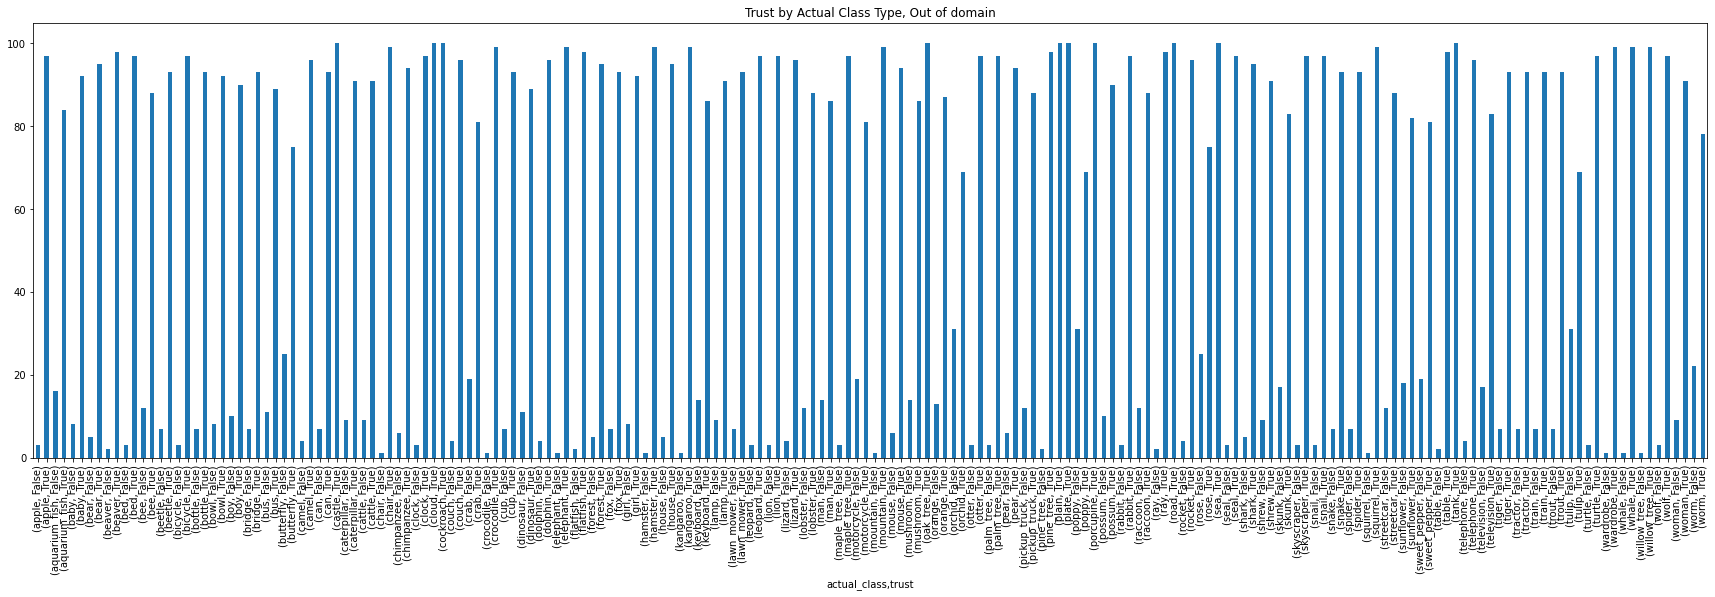

In [21]:
ood_trust.groupby(by = ['actual_class', 'trust']).size().plot(kind = 'bar', stacked = True, figsize = (30, 8), title = 'Trust by Actual Class Type, Out of domain')
plt.show()

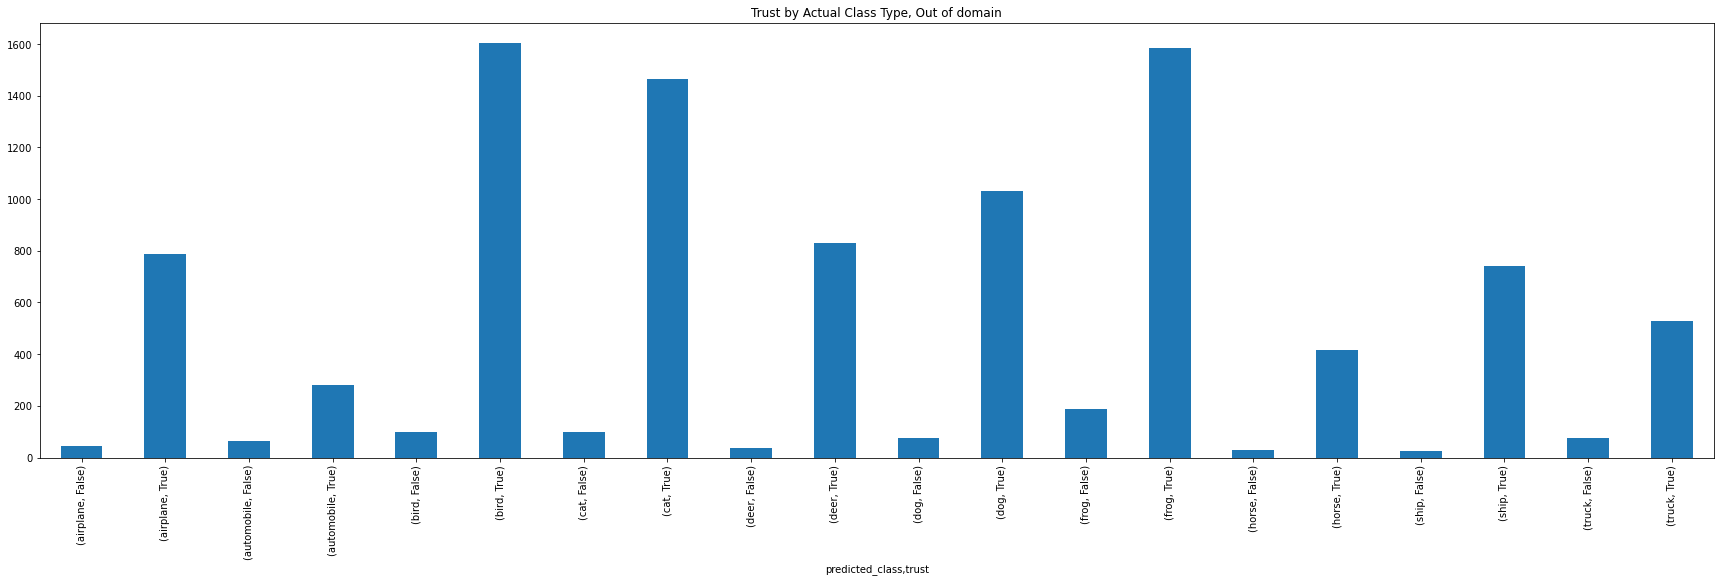

In [22]:
ood_trust.groupby(by = ['predicted_class', 'trust']).size().plot(kind = 'bar', stacked = True, figsize = (30, 8), title = 'Trust by Actual Class Type, Out of domain')
plt.show()

In [23]:
vals = ood_trust.groupby(by = ['predicted_class', 'actual_class', 'trust']).size().unstack().fillna(0).reset_index()
vals[vals.predicted_class == 'automobile']

trust,predicted_class,actual_class,False,True
88,automobile,apple,1.0,20.0
89,automobile,aquarium_fish,2.0,4.0
90,automobile,bear,0.0,1.0
91,automobile,bed,0.0,7.0
92,automobile,beetle,0.0,1.0
...,...,...,...,...
144,automobile,turtle,0.0,1.0
145,automobile,wardrobe,0.0,1.0
146,automobile,wolf,0.0,1.0
147,automobile,woman,1.0,1.0


In [24]:
ood_trust.groupby(by = ['actual_class', 'predicted_class', 'trust']).size().unstack().fillna(0)

trust                         False  True
actual_class predicted_class             
apple        automobile         1.0  20.0
             bird               0.0   9.0
             cat                2.0  30.0
             deer               0.0   3.0
             dog                0.0  13.0
...                             ...   ...
worm         dog                0.0   4.0
             frog               4.0   9.0
             horse              1.0   1.0
             ship               3.0  11.0
             truck              0.0   1.0

[891 rows x 2 columns]